#### demo: training a DND LSTM on a contextual choice task

This is an implementation of the following paper: 
```
Ritter, S., Wang, J. X., Kurth-Nelson, Z., Jayakumar, S. M., Blundell, C., Pascanu, R., & Botvinick, M. (2018).  
Been There, Done That: Meta-Learning with Episodic Recall. arXiv [stat.ML].  
Retrieved from http://arxiv.org/abs/1805.09692
```

In [ ]:
'''
If you are using google colab, uncomment and run the following lines!  
which grabs the dependencies from github
'''
# !git clone https://github.com/qihongl/dnd-lstm.git
# !cd dnd-lstm/src/
# import os
# os.chdir('dnd-lstm/src/')

In [1]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from task import ContextualChoice
from model import DNDLSTM as Agent
from utils import compute_stats, to_sqnp
from model.DND import compute_similarities
from model.utils import get_reward, compute_returns, compute_a2c_loss

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

In [2]:
'''init task'''
n_unique_example = 50
n_trials = 2 * n_unique_example
# n time steps of a trial
trial_length = 10
# after `tp_corrupt`, turn off the noise
t_noise_off = 5
# input/output/hidden/memory dim
obs_dim = 32
task = ContextualChoice(
    obs_dim=obs_dim, trial_length=trial_length,
    t_noise_off=t_noise_off
)

In [3]:
'''init model'''
# set params
dim_hidden = 32
dim_output = 2
dict_len = 100
learning_rate = 5e-4
n_epochs = 20
# init agent / optimizer
agent = Agent(task.x_dim, dim_hidden, dim_output, dict_len)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [4]:
'''train'''
log_return = np.zeros(n_epochs,)
log_loss_value = np.zeros(n_epochs,)
log_loss_policy = np.zeros(n_epochs,)

log_Y = np.zeros((n_epochs, n_trials, trial_length))
log_Y_hat = np.zeros((n_epochs, n_trials, trial_length))

# loop over epoch
for i in range(n_epochs):
    time_start = time.time()
    # get data for this epoch
    X, Y = task.sample(n_unique_example)
    # flush hippocampus
    agent.reset_memory()
    agent.turn_on_retrieval()

    # loop over the training set
    for m in range(n_trials):
        # prealloc
        cumulative_reward = 0
        probs, rewards, values = [], [], []
        h_t, c_t = agent.get_init_states()

        # loop over time, for one training example
        for t in range(trial_length):
            # only save memory at the last time point
            agent.turn_off_encoding()
            if t == trial_length-1 and m < n_unique_example:
                agent.turn_on_encoding()
            # recurrent computation at time t
            output_t, _ = agent(X[m][t].view(1, 1, -1), h_t, c_t)
            a_t, prob_a_t, v_t, h_t, c_t = output_t
            # compute immediate reward
            r_t = get_reward(a_t, Y[m][t])
            # log
            probs.append(prob_a_t)
            rewards.append(r_t)
            values.append(v_t)
            # log
            cumulative_reward += r_t
            log_Y_hat[i, m, t] = a_t.item()

        returns = compute_returns(rewards)
        loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
        loss = loss_policy + loss_value
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        log_Y[i] = np.squeeze(Y.numpy())
        log_return[i] += cumulative_reward / n_trials
        log_loss_value[i] += loss_value.item() / n_trials
        log_loss_policy[i] += loss_policy.item() / n_trials

    # print out some stuff
    time_end = time.time()
    run_time = time_end - time_start
    print(
        'Epoch %3d | return = %.2f | loss: val = %.2f, pol = %.2f | time = %.2f' %
        (i, log_return[i], log_loss_value[i], log_loss_policy[i], run_time)
    )

Epoch   0 | return = 5.86 | loss: val = 1.82, pol = 1.12 | time = 2.39
Epoch   1 | return = 7.45 | loss: val = 1.06, pol = -0.64 | time = 2.55
Epoch   2 | return = 7.85 | loss: val = 0.89, pol = -0.64 | time = 2.41
Epoch   3 | return = 7.72 | loss: val = 0.83, pol = -0.75 | time = 2.51
Epoch   4 | return = 7.64 | loss: val = 0.83, pol = -0.41 | time = 2.50
Epoch   5 | return = 7.78 | loss: val = 0.79, pol = -0.31 | time = 2.57
Epoch   6 | return = 8.27 | loss: val = 0.71, pol = -0.36 | time = 2.54
Epoch   7 | return = 8.13 | loss: val = 0.76, pol = -0.33 | time = 2.52
Epoch   8 | return = 8.15 | loss: val = 0.65, pol = -0.09 | time = 2.45
Epoch   9 | return = 8.08 | loss: val = 0.71, pol = -0.28 | time = 2.37
Epoch  10 | return = 8.05 | loss: val = 0.64, pol = -0.27 | time = 2.38
Epoch  11 | return = 8.34 | loss: val = 0.68, pol = -0.18 | time = 2.37
Epoch  12 | return = 8.33 | loss: val = 0.60, pol = -0.35 | time = 2.31
Epoch  13 | return = 8.14 | loss: val = 0.69, pol = -0.12 | time 

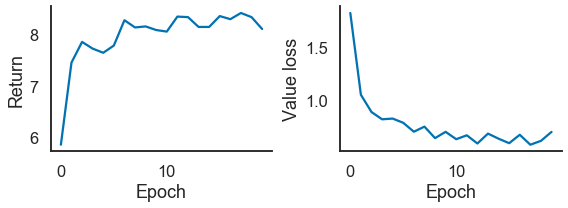

In [5]:
'''learning curve'''
f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(log_return)
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[1].plot(log_loss_value)
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')
sns.despine()
f.tight_layout()

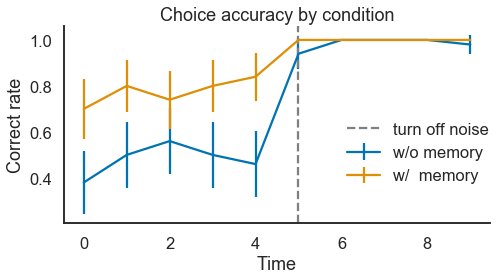

In [6]:
'''show behavior'''
corrects = log_Y_hat[-1] == log_Y[-1]
acc_mu_no_memory, acc_se_no_memory = compute_stats(
    corrects[:n_unique_example])
acc_mu_has_memory, acc_se_has_memory = compute_stats(
    corrects[n_unique_example:])

n_se = 2
f, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(range(trial_length), y=acc_mu_no_memory,
            yerr=acc_se_no_memory * n_se, label='w/o memory')
ax.errorbar(range(trial_length), y=acc_mu_has_memory,
            yerr=acc_se_has_memory * n_se, label='w/  memory')
ax.axvline(t_noise_off, label='turn off noise', color='grey', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Correct rate')
ax.set_title('Choice accuracy by condition')
f.legend(frameon=False, bbox_to_anchor=(1, .6))
sns.despine()
f.tight_layout()

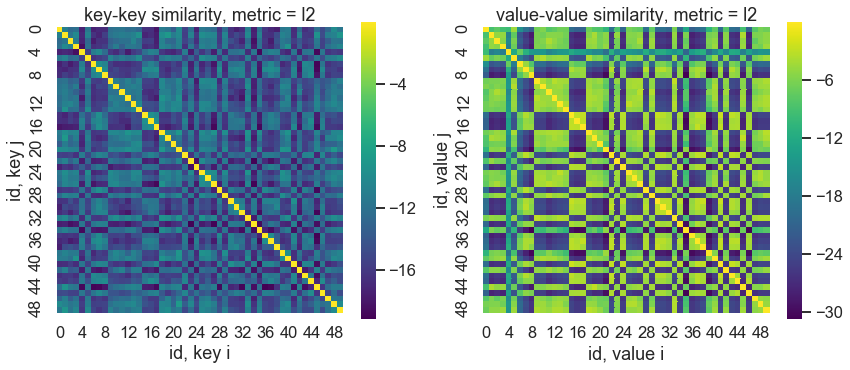

In [7]:
'''visualize keys and values'''
keys, vals = agent.get_all_mems()
n_mems = len(agent.dnd.keys)
dmat_kk, dmat_vv = np.zeros((n_mems, n_mems)), np.zeros((n_mems, n_mems))
for i in range(n_mems):
    dmat_kk[i, :] = to_sqnp(compute_similarities(
        keys[i], keys, agent.dnd.kernel))
    dmat_vv[i, :] = to_sqnp(compute_similarities(
        vals[i], vals, agent.dnd.kernel))

# plot
dmats = {'key': dmat_kk, 'value': dmat_vv}
f, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, (label_i, dmat_i) in enumerate(dmats.items()):
    sns.heatmap(dmat_i, cmap='viridis', square=True, ax=axes[i])
    axes[i].set_xlabel(f'id, {label_i} i')
    axes[i].set_ylabel(f'id, {label_i} j')
    axes[i].set_title(
        f'{label_i}-{label_i} similarity, metric = {agent.dnd.kernel}'
    )
f.tight_layout()

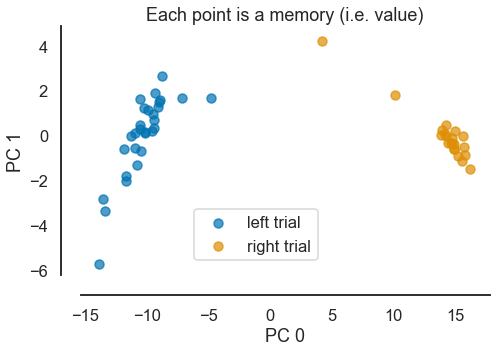

In [8]:
'''project memory content to low dim space'''

# convert the values to a np array, #memories x mem_dim
vals_np = np.vstack([to_sqnp(vals[i]) for i in range(n_mems)])
# project to PC space
vals_centered = (vals_np - np.mean(vals_np, axis=0, keepdims=True))
U, S, _ = np.linalg.svd(vals_centered, full_matrices=False)
vals_pc = np.dot(U, np.diag(S))

# pick pcs
pc_x = 0
pc_y = 1

# plot
f, ax = plt.subplots(1, 1, figsize=(7, 5))
Y_phase2 = to_sqnp(Y[:n_unique_example, 0])
for y_val in np.unique(Y_phase2):
    ax.scatter(
        vals_pc[Y_phase2 == y_val, pc_x],
        vals_pc[Y_phase2 == y_val, pc_y],
        marker='o', alpha=.7,
    )
ax.set_title(f'Each point is a memory (i.e. value)')
ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
ax.legend(['left trial', 'right trial'], bbox_to_anchor=(.6, .3))
sns.despine(offset=20)
f.tight_layout()